In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
import os
import cv2
import pandas as pd
import gzip
from tensorflow.keras import backend as K
import tensorflow as tf 
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal
import random 

import numpy as np
from numpy.random import randn
from numpy.random import randint
import os
import cv2
import pandas as pd
import gzip
from tensorflow.keras import backend as K
import tensorflow as tf 
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal
import random 
from tensorflow.keras.layers import Conv2D, Input, Dense, Activation, Reshape, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, Dropout, BatchNormalization

######################################## RANDOM SEED:
random.seed(13)

#epsilon set according to BIGGAN https://arxiv.org/pdf/1809.11096.pdf

def _l2normalizer(v, epsilon=1e-4):
    return v / (K.sum(v**2)**0.5 + epsilon)


def power_iteration(W, u, rounds=1):
    '''
    Accroding the paper, we only need to do power iteration one time.
    '''
    _u = u

    for i in range(rounds):
        _v = _l2normalizer(K.dot(_u, W))
        _u = _l2normalizer(K.dot(_v, K.transpose(W)))

    W_sn = K.sum(K.dot(_u, W) * _v)
    return W_sn, _u, _v

"""
Convolution 2D with spectral normalization
"""
class SNConv2D(Conv2D):
    def __init__(self, filters, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2D, self).__init__(filters, **kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.

        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2D, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-1], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):

        outputs = K.conv2d(inputs,
                           self.compute_spectral_normal(training=training),
                           strides=self.strides, padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2D, self).compute_output_shape(input_shape)

"""
Transposed Convolution 2D with spectral normalization
"""
class SNConv2DTranspose(Conv2DTranspose):
    def __init__(self, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2DTranspose, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2DTranspose, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-2], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        out_pad_h = out_pad_w = None

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_output_length(
            height, kernel_h, self.padding, stride=stride_h)
        out_width = conv_utils.deconv_output_length(
            width, kernel_w, self.padding, stride=stride_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        outputs = K.conv2d_transpose(
            inputs,
            self.compute_spectral_normal(training=training),
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format
        )

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2DTranspose, self).compute_output_shape(input_shape)

    
# define the standalone discriminator model
# A best practice involves using an embedding
# layer followed by a fully connected layer with a linear activation that scales the embedding to
# the size of the image before concatenating it in the model as an additional channel or feature
# map. A version of this recommendation was described in the 2015 paper titled Deep Generative
# Image Models using a Laplacian Pyramid of Adversarial Networks.
    
def define_CNN(in_shape=(64,64,3)): # HERE

    
    # input layer:
    in_image = Input(shape=in_shape) ##

        
    # kernel initializer:
    init = RandomNormal(stddev=0.02)
    ##
    # downsample to 32x32
    fe = SNConv2D(128, kernel_size=4, strides=(4,4), padding='same', kernel_initializer=init, spectral_normalization=True)(in_image) ##in_image
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 16x16
    fe = SNConv2D(128, kernel_size=4, strides=(4,4), padding='same', kernel_initializer=init, spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 8x8
    fe = SNConv2D(128, kernel_size=4, strides=(4,4), padding='same', kernel_initializer=init, spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 4x4
    fe = SNConv2D(128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init, spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample 2x2
    fe = SNConv2D(128, kernel_size=4, strides=(2,2), padding='same',kernel_initializer=init, spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    
    # flatten feature maps
    fe = Flatten()(fe)
    
    # output about fake/real image:
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(inputs=in_image, outputs=out)
    return model

In [2]:
import numpy as np
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt

def elastic_transform(image, alpha, sigma, random_state=None):
    """
       Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    #print(x.shape)
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

def load_images(dataset, images_directory, img_shape):
    X = []
    for i, myid in enumerate(dataset):
        image = load_img(images_directory + "/" + myid, target_size=img_shape[:2])
        image = (img_to_array(image) - 127.5) / 127.5 # from [0, 255] to [-1, 1]
        image = image[25:153, 45:173]
        image = cv2.resize(src=image, dsize=(64, 64))
        X.append(image)
    X = np.array(X)
    return X


######### LOAD DATASET:
def load_dataset(how_many, images_directory = 'img_align_celeba_nozip', img_shape = (178, 218, 3)):  

    RandomListOfIntegers = [random.randint(0,202598) for iter in range(how_many)]
    celeba_img = np.sort(os.listdir(images_directory))
    images_id = celeba_img[RandomListOfIntegers]
    images = load_images(images_id, images_directory, img_shape)
    labels = np.zeros(how_many)
    dataset = [images, labels]
    return dataset

# plot of generated images
def plot_images(examples, n_test_images):
    # plot images
    for i in range(n_test_images):
        # define subplot
        plt.subplot(n_test_images/4, 4, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()


In [3]:
############### PARAMETERS:
how_many = 10000 ############################ number of images to use for training

n_classes=2 # just 2 possible value for each attribute

################# MODELS:
# create the discriminator
model = define_CNN()
#d_model.summary()

real_dataset = load_dataset(how_many)

# Test the elastic deformation:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


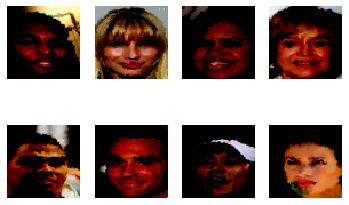

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


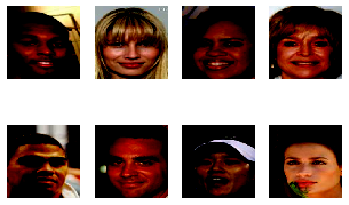

In [4]:
deformed_images=[]
for i in range(len(real_dataset[0])):
    img = real_dataset[0][i,:,:]
    deformed_img = elastic_transform(img,5,0.9)
    deformed_images.append(deformed_img)
    
deformed_images = np.array(deformed_images)
labels = np.ones(how_many)
deformed_dataset = [deformed_images, labels]

plot_images(deformed_images,8)
plot_images(real_dataset[0],8)

In [5]:
import copy
dataset = [np.concatenate([real_dataset[0],deformed_dataset[0]]), np.concatenate([real_dataset[1],deformed_dataset[1]])] 
new_dataset = copy.deepcopy(dataset)
indexes = [ i for i in range(how_many*2)]
random.shuffle(indexes)
for i in range(how_many*2):
    new_dataset[0][i] = dataset[0][indexes[i]]
    new_dataset[1][i] = dataset[1][indexes[i]]

train_data = dataset[0][:int((how_many*2)*3/4)]
#print(train_data.shape)
train_labels = dataset[1][:int((how_many*2)*3/4)]
#print(train_labels.shape)

test_data = dataset[0][int((how_many*2)*3/4)+1:]
#print(test_data.shape)
test_labels = dataset[1][int((how_many*2)*3/4)+1:]
#print(test_labels.shape)

In [6]:
# divide dataset into this number of batches:
batch_size = 32 # number of images per batch
9
n_epochs = 100

opt = Adam(lr=0.00001, beta_1=0.9)
model.compile(loss=["binary_crossentropy"], optimizer=opt, metrics=['accuracy'])

model.fit(train_data, train_labels, batch_size=batch_size, epochs= n_epochs, verbose=1, validation_data=(test_data, test_labels))

score = model.evaluate(test_data, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save('quality_index_model.h5')

Train on 15000 samples, validate on 4999 samples
Epoch 1/100
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.6755 - accuracy: 0.6363 - val_loss: 1.0246 - val_accuracy: 0.0000e+00
Epoch 2/100
15000/15000 [==============================] - 16s 1ms/sample - loss: 0.6408 - accuracy: 0.6667 - val_loss: 1.0832 - val_accuracy: 0.0000e+00
Epoch 3/100
15000/15000 [==============================] - 16s 1ms/sample - loss: 0.6400 - accuracy: 0.6667 - val_loss: 1.0653 - val_accuracy: 0.0000e+00
Epoch 4/100
15000/15000 [==============================] - 16s 1ms/sample - loss: 0.6412 - accuracy: 0.6667 - val_loss: 1.0392 - val_accuracy: 0.0000e+00
Epoch 5/100
15000/15000 [==============================] - 16s 1ms/sample - loss: 0.6376 - accuracy: 0.6667 - val_loss: 1.0452 - val_accuracy: 0.0000e+00
Epoch 6/100
15000/15000 [==============================] - 16s 1ms/sample - loss: 0.6381 - accuracy: 0.6667 - val_loss: 1.0517 - val_accuracy: 0.0000e+00
Epoch 7/100
15000/15000 [==

In [10]:
from tensorflow.keras.models import load_model
quality_model = load_model('quality_index_model.h5', custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D})

prediction = model.predict(real_dataset[0][0:10])
print(prediction)

prediction = model.predict(deformed_dataset[0][0:10])
print(prediction)

print(" closer to 1 means detected as deformed, closer to 0 means detected ad original")

[[0.0174883 ]
 [0.35710692]
 [0.001876  ]
 [0.00166079]
 [0.12455353]
 [0.00492913]
 [0.00546196]
 [0.00564307]
 [0.00985871]
 [0.00724415]]
[[0.92441773]
 [0.9816787 ]
 [0.9224082 ]
 [0.9305568 ]
 [0.9508183 ]
 [0.9666634 ]
 [0.45275873]
 [0.96568584]
 [0.99101347]
 [0.9744109 ]]
 closer to 1 means detected as deformed, closer to 0 means detected ad original


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


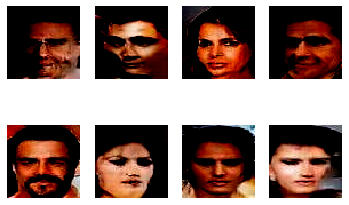

 closer to 1 means detected as deformed, closer to 0 means detected ad original
[[0.17932907]
 [0.02543494]
 [0.00110149]
 [0.01818246]
 [0.00119638]
 [0.02828401]
 [0.00065315]
 [0.09194243]]


In [11]:
import cv2

images= []
for i in range(8):
    

    img=cv2.imread("test_image" + str(i) + ".jpg")
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #print(raw_image)
    img = np.array(img ,dtype='float32')
    #plt.imshow(img_cvt)
    #plt.show()
    img =  (img - 127.5) / 127.5 # from [0, 255] to [-1, 1]
    images.append(img)
    
plot_images(np.array(images),8)
predictions = model.predict(np.array(images, dtype='float32'))
print(" closer to 1 means detected as deformed, closer to 0 means detected ad original")
print(predictions)

# compare with FID:

In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
import os
import cv2
import pandas as pd
import gzip
from tensorflow.keras import backend as K
import tensorflow as tf 
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal
import random 
from tensorflow.keras.layers import Conv2D, Input, Dense, Activation, Reshape, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, Dropout, BatchNormalization

#epsilon set according to BIGGAN https://arxiv.org/pdf/1809.11096.pdf

def _l2normalizer(v, epsilon=1e-4):
    return v / (K.sum(v**2)**0.5 + epsilon)


def power_iteration(W, u, rounds=1):
    '''
    Accroding the paper, we only need to do power iteration one time.
    '''
    _u = u

    for i in range(rounds):
        _v = _l2normalizer(K.dot(_u, W))
        _u = _l2normalizer(K.dot(_v, K.transpose(W)))

    W_sn = K.sum(K.dot(_u, W) * _v)
    return W_sn, _u, _v

"""
Convolution 2D with spectral normalization
"""
class SNConv2D(Conv2D):
    def __init__(self, filters, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2D, self).__init__(filters, **kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.

        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2D, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-1], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):

        outputs = K.conv2d(inputs,
                           self.compute_spectral_normal(training=training),
                           strides=self.strides, padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2D, self).compute_output_shape(input_shape)

"""
Transposed Convolution 2D with spectral normalization
"""
class SNConv2DTranspose(Conv2DTranspose):
    def __init__(self, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2DTranspose, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2DTranspose, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-2], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        out_pad_h = out_pad_w = None

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_output_length(
            height, kernel_h, self.padding, stride=stride_h)
        out_width = conv_utils.deconv_output_length(
            width, kernel_w, self.padding, stride=stride_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        outputs = K.conv2d_transpose(
            inputs,
            self.compute_spectral_normal(training=training),
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format
        )

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2DTranspose, self).compute_output_shape(input_shape)
    
class PixelNormalization(Layer):
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)

    def call(self, inputs):
        # Calculate square pixel values
        values = inputs**2.0
        # Calculate the mean pixel values
        mean_values = tf.keras.backend.mean(values, axis=-1, keepdims=True)
        # Ensure the mean is not zero
        mean_values += 1.0e-8
        # Calculate the sqrt of the mean squared value (L2 norm)
        l2 = tf.keras.backend.sqrt(mean_values)
        # Normalize values by the l2 norm
        normalized = inputs / l2
        return normalized

    def compute_output_shape(self, input_shape):
        return input_shape
    
class MinibatchStdev(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs):
        # calculate the mean value for each pixel across channels
        mean = tf.keras.backend.mean(inputs, axis=0, keepdims=True)
        # calculate the squared differences between pixel values and mean
        squ_diffs = tf.keras.backend.square(inputs - mean)
        # calculate the average of the squared differences (variance)
        mean_sq_diff = tf.keras.backend.mean(squ_diffs, axis=0, keepdims=True)
        # add a small value to avoid a blow-up when we calculate stdev
        mean_sq_diff += 1e-8
        # square root of the variance (stdev)
        stdev = tf.keras.backend.sqrt(mean_sq_diff)
        # calculate the mean standard deviation across each pixel coord
        mean_pix = tf.keras.backend.mean(stdev, keepdims=True)
        # scale this up to be the size of one input feature map for each sample
        shape = tf.keras.backend.shape(inputs)
        output = tf.keras.backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        # concatenate with the output
        combined = tf.keras.backend.concatenate([inputs, output], axis=-1)
        return combined

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        # create a copy of the input shape as a list
        input_shape = list(input_shape)
        # add one to the channel dimension (assume channels-last)
        input_shape[-1] += 1
        # convert list to a tuple
        return tuple(input_shape)
    
def generate_latent_points(latent_dim, n_samples, n_attr, n_classes=2): # two calsses: 0 and 1
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.randint(n_classes, size=(n_samples, n_attr))
    return [z_input, labels]

In [2]:
from tensorflow.keras.models import load_model
quality_model = load_model('quality_index_model10k100epo_5_0.9.h5', custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D})
quality_scores =[]

n_images = 10000

latent_points, labels = generate_latent_points(128, n_images, 40)

i=1
while i <= 100:
    print(i)
    gan_model = load_model('GAN models/gan_generator' + str(i)+ 'epoch.h5', custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D, 'PixelNormalization':PixelNormalization})
    images = gan_model.predict(latent_points)    
    predictions = quality_model.predict(np.array(images, dtype='float32'))
    mean_prediction = np.mean(np.array(predictions))
    quality_scores.append(mean_prediction)
    if i==1:
        i =5
    else:
        i = i+5
    


quality_scores = np.array(quality_scores)
quality_scores = quality_scores/np.max(quality_scores)

1
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


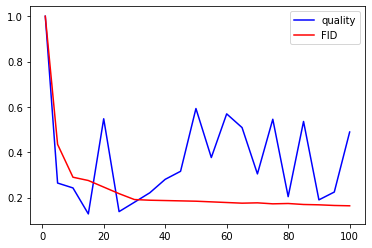

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
ax.plot(x, quality_scores,'b')
FID_scores = np.array([69,30,20,19,17,15,13.2,13,12.9,12.8,12.7,12.5,12.3,12.1,12.2,11.9,12,11.7,11.6,11.4,11.3]) # computed in another file
FID_scores = FID_scores /np.max(FID_scores)
ax.plot(x, FID_scores, 'r')
ax.legend(['our_metric','FID'])
